In [1]:
#import the spectroscopic module from the tshirt pipeline
from tshirt.pipeline import spec_pipeline

import sys
sys.path.insert(1, '/home/kglidic/Software/tshirt_files/tshirt/Corot1_Data/')
#Import the required scripts: RECTE charge correction & Transit modeling functions
import Charge_Correction_Functions
from Charge_Correction_Functions import RECTE,RECTEMulti,calculate_correction_fast,charge_correction

#import basic plotting libraries/set plot settings
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

#import yaml to read in the parameter file
import yaml

#Basic imports
import os
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import pandas as pd
from astropy.time import Time
from copy import deepcopy
import time
from multiprocessing import Pool

#modeling transit/eclipse light curves
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import batman
import corner
import emcee

#to fix errors
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
import glob
import random
import pathlib

Could not import ccdproc, so image processing may not work


Loading BokehJS ...

Loading BokehJS ...

In [18]:
class lightcurve_model(object):
    
    def __init__(self, tshirt_obj, planet_file):
        """
        Called when an object is created from the class to initialize (assign values) to the attributes of the class.
            
        Parameters:
        -----------
        self: keyword
            Class object
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        planet_file: YAML file
            The YAML file containing desired planet parameters
        """
        self.planet_file = planet_file  #Assign the object a planet parameter YAML file
        with open(planet_file, "r") as stream:  #Open the planet parameter YAML file; call it planet_data
            self.planet_data = yaml.safe_load(stream)
            
        results = tshirt_obj.get_wavebin_series()  #Obtain a table of the the wavelength-binned time series from tshirt.
        raw_results = results[0].to_pandas()  #Put the flux values and time in a pandas table
        time_correction = self.barycenter_correction(tshirt_obj)  #Call the barycenter time correction function. Will return correction in days. 
        self.x = raw_results['Time'].values+time_correction  #Assign the object's time column data in terms of days accounting for Solar barycenter correction
        
        self.im = self.median_image(tshirt_obj)  #Define the median image data (im) by calling the median_image function
        
        head = fits.getheader(tshirt_obj.fileL[0], extname="PRIMARY")  #Grab the header information from one of the fits files
        self.exptime=head['EXPTIME']  #Define the exposure time from the header information
        
        #Obtain a table of wavelength bins (nbin=1), with theoretical noise and measured standard deviation across time.
        table_noise = tshirt_obj.print_noise_wavebin(nbins=1)
        table_noise=table_noise.to_pandas() #convert to a pandas table
        #Defining the global xList parameter needed in the model functions with RECTE
        Disp_st = table_noise['Disp St'][0] #Start of the dispersion range
        Disp_end = table_noise['Disp End'][0] #End of the dispersion range
        Disp_xList = np.arange(Disp_st, Disp_end,1) #Return Numpy array of evenly spaced values within a given interval. 
        self.xList = Disp_xList
        
    def barycenter_correction(self,tshirt_obj):
        '''
        Calculates the barycentric time difference 
        
        Parameters
        ----------
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        '''
        results = tshirt_obj.get_wavebin_series()              #Obtain a table of the the wavelength-binned time series from tshirt.
        raw_results = results[0].to_pandas()                   #Put the flux values and time in a pandas table

        head = fits.getheader(tshirt_obj.fileL[0])             #Grab the header information from one of the fits files
            
        expStartJD = head['EXPSTART'] + 2400000.5              #Define the exposure start time in Julian Days
         
        raw_results = Time(raw_results['Time'][0],format='jd') #Redefine the raw results table making sure the time column is in Julian Days
            
        coord = SkyCoord('06 48 19.1724141241 -03 06 07.710423478',unit=(u.hourangle,u.deg)) #Define Coordinates and Location
        loc = EarthLocation.of_site('keck')
            
        diff = raw_results.light_travel_time(coord,location=loc) #Find the time difference 
            
        return (diff / u.day).si
        
    def median_image(self, tshirt_obj, showPlot=False):
        '''
        Generates a median image of the fits files 
        
        Parameters
        ----------
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        showPlot: bool
            Make the plot visible? The Default is "False"
        '''
        planet_data = self.planet_data  #Call the planet file data
        
        new_dir = pathlib.Path(planet_data['BaseDir'], 'Median_Images')  #Establish a path to the saved data based on the given base directory
        new_dir.mkdir(parents=True, exist_ok=True)  #Make the new directory
        filename = os.path.join(new_dir,"{}_MedianImage_{}".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName']))  #Generate a name for the median image file based on planet parameters
        
        #If the previously defined lightcurve_file exists and the recalculation parameter is set to False, read it in. 
        if (os.path.exists(filename+".fits") == True):
            medianImage = fits.getdata(filename+".fits")
        else:
            head = fits.getheader(tshirt_obj.fileL[0], extname='SCI')  #Grab the SCI header information from one of the fits files

            cube3d = np.zeros([len(tshirt_obj.fileL),head['NAXIS2'],head['NAXIS1']])  #Generate a 3D array of zeros; the size is based on header information
            
            for ind,oneFile in enumerate(tshirt_obj.fileL):  #Loop through all the fits files and append the image data to the 3D array 
                cube3d[ind,:,:] = fits.getdata(oneFile,extname='SCI')
    
            medianImage = np.median(cube3d,axis=0)  #Find the median of the data
                    
            outHDU = fits.PrimaryHDU(medianImage,head)  #Write the median image data to a file
            outHDU.writeto(filename+".fits", overwrite=True)
            plt.imsave(filename+".pdf",medianImage)  #Save the median image as a pdf                                           
            
        if showPlot==True:
            medianImage_plot = plt.imshow(medianImage)  #If True, Plot the median image 
            plt.title("{} Median Image {}".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName']))
            plt.xlabel("x-pixels")
            plt.ylabel("y-pixels")            
            plt.show()
        else:
            None
    
        return medianImage
    
    def transit_model(self, x, rp, a, b):
        '''
        Models transit light curve using Python package `batman` based on initial parameters stored in params_transit.
        
        Parameters
        ----------
        x: array
            Time in Julian days    
        rp: int
            Planet-to-star radius ratio
        a: int
            Baseline linear regression y-intercept applied to the modeled normalized flux
        b: int
            Baseline linear regression slope applied to the modeled normalized flux
        '''
        planet_data = self.planet_data                            #Call the planet file data
        
        params_transit = batman.TransitParams()                   #Object to store transit parameters
        
        params_transit.t0 = planet_data['t0']                     #Time of inferior conjunction (days)
        params_transit.per = planet_data['per']                   #Orbital period (days)
        params_transit.a = planet_data['ax']                      #Semi-major axis (in units of stellar radii)
        params_transit.inc = planet_data['inc']                   #Orbital inclination (in degrees)
        params_transit.ecc = planet_data['ecc']                   #Eccentricity
        params_transit.w = planet_data['w']                       #Longitude of periastron (in degrees)
        params_transit.limb_dark = planet_data['limb_dark']       #Limb darkening model
        params_transit.u = planet_data['u']                       #Limb darkening coefficients [u1, u2, u3, u4]
        
        params_transit.rp = rp                                    #Planet-to-star radius ratio - Will depend on function input
        m = batman.TransitModel(params_transit, x)                #Initializes model
        
        #Modifying the linear regression slope: Julian Date(x) - Initial Julian Date(x0) 
        x0 = np.min(x)
        flux = m.light_curve(params_transit)*(a+b*(x-x0))         #Calculate the light curve modeled flux
        return flux
    
    def transit_model_RECTE(self, x, rp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
        '''
        Models transit light curve using Python package `batman` based on initial parameters stored in params_transit. These transit models account for charge trapping systematics using Python package `RECTE`. 

        Parameters
        ----------
        x: array
            Time in Julian days
        rp: int
            Planet-to-star radius ratio
        a: int
            Baseline linear regression y-intercept applied to the modeled normalized flux
        b: int
            Baseline linear regression slope applied to the modeled normalized flux
        trap_pop_s: int
            (default=0) number of initially occupied traps -- slow poplulation
        trap_pop_f: int
            (default=0) number of initially occupied traps -- fast poplulation
        dtrap_s: int
            (default=0, can be either number or list) number of extra
            trapped charge carriers added in the middle of two orbits
            -- slow population. If it is a number, it assumes that all
            the extra added trap charge carriers are the same
        dtrap_f: int
            (default=0, can be either number or list) number of extra
             trapped charge carriers added in the middle of two orbits
            -- fast population. If it is a number, it assumes that all
            the extra added trap charge carriers are the same
        '''
            
        planet_data = self.planet_data #Call the planet file data
        
        im = self.im  #Call the median image

        exptime = self.exptime #Call the exposure time
        
        xList = self.xList  #Call the dispersion range

        #Define the initial flux for the model based on the regular transit_model function
        flux = self.transit_model(x,rp,a,b)

        #Calculate the ramp profile in the initial flux data
        ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])

        #Return the modified flux based on the ramp profile in the data
        flux_modified = flux*np.mean(ramp,axis=0)         #Calculate the light curve
        return flux_modified
    
    def eclipse_model(self, x, fp, a, b):
        '''
        Models eclipse light curve using Python package `batman` based on initial parameters stored in params_eclipse.

        Parameters
        ----------
        x: array
            Time in Julian days    
        fp: int
            Planet-to-star flux ratio
        a: int
            Baseline linear regression y-intercept applied to the modeled normalized flux
        b: int
            Baseline linear regression slope applied to the modeled normalized flux
        '''
        planet_data = self.planet_data                            #Call the planet file data

        params_eclipse = batman.TransitParams()                   #Object to store secondary eclipse parameters

        params_eclipse.t0 = planet_data['t0']                     #Time of inferior conjunction (days)
        params_eclipse.per = planet_data['per']                   #Orbital period (days)
        params_eclipse.a = planet_data['ax']                      #Semi-major axis (in units of stellar radii)
        params_eclipse.inc = planet_data['inc']                   #Orbital inclination (in degrees)
        params_eclipse.ecc = planet_data['ecc']                   #Eccentricity
        params_eclipse.w = planet_data['w']                       #Longitude of periastron (in degrees)
        params_eclipse.limb_dark = planet_data['limb_dark']       #Limb darkening model
        params_eclipse.u = planet_data['u']                       #Limb darkening coefficients [u1, u2, u3, u4]
        params_eclipse.rp =  planet_data['rp']                    #Planet-to-star radius ratio
        params_eclipse.t_secondary = planet_data['t_secondary']   #The central eclipse time

        params_eclipse.fp = fp/1000000                            #Planet-to-star flux ratio (fp) is in ppm - Will depend on function input

        m = batman.TransitModel(params_eclipse, x, transittype="secondary") #Initializes model

        #Modifying the linear regression slope: Julian Date(x) - Initial Julian Date(x0) 
        x0 = np.min(x)
        flux = m.light_curve(params_eclipse)*(a+b*(x-x0))         #Calculate the light curve
        return flux
    
    def eclipse_model_RECTE(self, x, fp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
        '''
        Models eclipse light curve using Python package `batman` based on initial parameters stored in params_eclipse. These transit models         account for charge trapping systematics using Python package `RECTE`. 

        Parameters
        ----------
        x: array
            Time in Julian days 
        fp: int
            Planet-to-star flux ratio
        a: int
            Baseline linear regression y-intercept applied to the modeled normalized flux
        b: int
            Baseline linear regression slope applied to the modeled normalized flux
        trap_pop_s: int
            (default=0) number of initially occupied traps -- slow poplulation
        trap_pop_f: int
            (default=0) number of initially occupied traps -- fast poplulation
        dTrap_s: int
            (default=0, can be either number or list) number of extra
            trapped charge carriers added in the middle of two orbits
            -- slow population. If it is a number, it assumes that all
            the extra added trap charge carriers are the same
         dtrap_f: int
            (default=0, can be either number or list) number of extra
             trapped charge carriers added in the middle of two orbits
            -- fast population. If it is a number, it assumes that all
            the extra added trap charge carriers are the same 
        '''
        
        planet_data = self.planet_data #Call the planet file data
        
        im = self.im  #Call the median image

        exptime = self.exptime #Call the exposure time
        
        xList = self.xList #Call the dispersion range

        #Define the initial flux for the model based on the regular eclipse_model function
        flux = eclipse_model(x,fp,a,b)

        #Define the ramp profile in the initial flux data
        ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])

        #return the modified flux based on the ramp profile in the data
        flux_modified = flux*np.mean(ramp,axis=0)  #Calculate the light curve
        return flux_modified
    
    def optimize_batman_model(self, tshirt_obj, model, nbins=10, showPlot=False, recalculate=False):
        """
        Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
        This function does NOT consider `RECTE` charge trapping parameters. 
        This function utilizies the scipy.optimize.curve_fit model fitting approach. 
        
        Parameters
        ----------
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        model: function
            A function that models either transits or secondary eclipses. Must be previously defined (transit_model or eclipse_model).
        nbins: int
            The number of wavelength bins. The Default is "nbins=10".
        showPlot: bool
            Make the plot visible? The Default is "False"
        recalculate: bool
            Recalculate the model optimizations? The Default is "False"
        """
        planet_data = self.planet_data #Call the planet file data
            
        #Obtain a table of the the wavelength-binned time series (with `tshirt`). 
        #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
        results = tshirt_obj.get_wavebin_series(nbins=nbins)
        raw_results = results[0].to_pandas()
        raw_results_errors = results[1].to_pandas()
        
        #Define the axis columns as well as the corresponding error columns.
        ydata_columns = raw_results.columns[1:].values #Skip over the time column
        ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
        xdata = self.x #Time column data in terms of days accounting for Solar barycenter correction
    
        #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
        table_noise = tshirt_obj.print_noise_wavebin(nbins=nbins)
        table_noise=table_noise.to_pandas() #convert to a pandas table
        
        #Wavelength calibration to turn the dispersion pixels into wavelengths. 
        wavelength_list = tshirt_obj.wavecal(table_noise['Disp Mid'],waveCalMethod = planet_data['WaveCalMethod'])
        
        #Define empty lists to store scipy.optimize.curve_fit results.
        popt_list=[] #Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
        pcov_list=[] #List of one standard deviation errors on the parameters.
        
        #Plotting options
        if(showPlot==True):
            
            fig, (ax, ax2) = plt.subplots(1,2,figsize=(20,10),sharey=False) #Set up the figure space
        
        #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
        if(model==self.transit_model):
            text = 'fit: rp=%5.3f, a=%5.3f, b=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            rp_guess = input("Pick a guess value for the planet-to-star radius ratio (rp):")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a):") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the Baseline linear regression slope applied to the normalized modeled flux (b):")
            print("To Confirm, your Transit Model guess values were: rp="+str(rp_guess)+", a="+str(a_guess)+", b="+str(b_guess))
            p0 = [float(rp_guess),float(a_guess),float(b_guess)] #each guess value in the list corresponds to the parameter order in text
        elif(model==self.eclipse_model):
            text = 'fit: fp=%5.3f, a=%5.3f, b=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            fp_guess = input("Pick a guess value for the planet-to-star flux ratio (fp in ppm):")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a):") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the  Baseline linear regression slope applied to the normalized modeled flux (b):")
            print("To Confirm, your Secondary Eclipse Model guess values were: fp="+str(fp_guess)+"(ppm)"+", a="+str(a_guess)+", b="+str(b_guess))
            p0 = [float(fp_guess),float(a_guess),float(b_guess)] #each guess value in the list corresponds to the parameter order in text
        else: 
            print("Invalid Model Input") #This function only works on the above previously defined models!
        
        #Establsih a color map index, to be iterated over, based on the number of wavebins defined. 
        color_idx_range = np.linspace(0.3, 0.8, nbins)
        
        #Trim the data used in the model. Exclude the first orbit in each visit since RECTE is not optimized here and the ramp profile is still prevalent.
        tshirt_obj.plot_wavebin_series(interactive=True) #Use the interactive plot to find where the first visit ends
        
        data_trim = int(input('\033[91m'+"This model excludes the first orbit in each visit since the ramp profile is not considered. Use the interactive plot to determine at what index to trim the data:"+'\033[91m'))
    
        #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. will loop over a color index and bin number for plotting purposes.  
        for columns,columns_errors,bin_number,color_idx,wavelength in zip(ydata_columns,ydata_errors_columns,np.arange(nbins),color_idx_range,wavelength_list):
            
            #Trim the data used in the model. Exclude the first orbit in each visit since RECTE is not optimized here and the ramp profile is still prevalent.
            xdata_trimmed = xdata[data_trim:]  
            ydata_trimmed = raw_results[columns][data_trim:]
            ydata_error_trimmed = raw_results_errors[columns_errors][data_trim:].tolist() #Convert error data to a list in order to use in scipy.optimize.curve_fit 
    
            new_dir = pathlib.Path(planet_data['BaseDir'], 'optimize_batman_model')  #Establish a path to the saved data based on the given base directory
            OptimalParams_file = os.path.join(new_dir,"{}_OptimalParams_{}_wavelength_ind_{}.csv".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
    
            if (os.path.exists(OptimalParams_file) == True ) and (recalculate == False):
                dat = ascii.read(OptimalParams_file)
                popt = np.array(dat['Optimal Values']) #read in the optimized parameter values
                pcov_diag = np.array(dat['Estimated Covariance']) #read in the one standard deviation errors on the parameters.
            else: 
                #Call and run scipy.optimize.curve_fit. 
                #Returns an array of optimal values for the parameters (popt) and an array for the the estimated covariance of popt (pcov).
                popt, pcov = curve_fit(model,xdata_trimmed,ydata_trimmed,sigma=ydata_error_trimmed,p0=p0)    
                pcov_diag = np.sqrt(np.diag(pcov)) #To compute one standard deviation errors on the parameters
                
                new_dir.mkdir(parents=True, exist_ok=True)  #Make the new directory
                dat = Table()
                dat['Optimal Values'] = popt
                dat['Estimated Covariance'] = pcov_diag
                dat.write(OptimalParams_file,overwrite=True)  #Write the light curve data to a file
    
            #Append these returned arrays into the previously defined empty lists.
            popt_list.append(popt)
            pcov_list.append(pcov_diag)
            
            #Light Curve Plotting Options
            if(showPlot==True):
                
                #This line is used to save light curve modeling results to a specific folder in order to streamline previously run data. (Can be altered)
                lightcurve_file = os.path.join(new_dir,"{}_LightCurve_{}_wavelength_ind_{}.csv".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
    
                #If the previously defined lightcurve_file exists and the recalculation parameter is set to False, read it in. 
                if (os.path.exists(lightcurve_file) == True ) and (recalculate == False):
                    dat_lightcurve = ascii.read(lightcurve_file)
                    print(dat_lightcurve)
                    Time = np.array(dat_lightcurve['Time'])
                    
                    #Saftey check if the saved time and user input trimmed data is equal in length. 
                    if(len(Time)!=len(xdata_trimmed)):
                        raise Exception("The length of the trimmed data (based on index input) does not match the saved results. Re-input the index or set recalculate=True.")
                    #Saftey check If the Time read does not match the xdata (time) within a tolerance raise an error. 
                    elif np.allclose(Time,xdata_trimmed,rtol=1e-15) == False:
                        raise Exception("Times don't match")
                    
                    ymodel = np.array(dat_lightcurve['ymodel'])
                    
                #If the previously defined lightcurve_file does not exsit or if the recalculation parameter is set to True
                else: 
                    ymodel = model(xdata_trimmed, *popt) #define the model based on optimized parameters (*popt)
                    #Create a table for these results and save them to the lightcurve_file defined previously. 
                    dat_lightcurve = Table()
                    dat_lightcurve['Time'] = xdata_trimmed
                    dat_lightcurve['ymodel'] = ymodel
                    dat_lightcurve.write(lightcurve_file,overwrite=True)
                
                offset = 0.007 #set an offset between each wavelegnth's light curve.
                
                #The first plot (ax) is the original light curves with the models overlaid.
                ax.plot(xdata_trimmed, ymodel-bin_number*offset, 'r-',
                        label=text % tuple(popt))  #The *popt will grab the optimized parameters required for the model. 
                ax.plot(xdata, raw_results[columns]-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),alpha=0.8) #Plot the time data vs. initial flux data - no model
                
                #plot labels
                ax.set_xlabel('Time (BJD)')
                ax.set_ylabel('Normalized Flux')
                ax.set_title(str(tshirt_obj.param['srcName'])+' Light Curves')
                
                #Plot the residuals
                ax2.plot(xdata_trimmed, (ydata_trimmed-ymodel)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx))
                ax2.set_ylabel('Residuals')
                ax2.set_xlabel('Time (BJD)')
                ax2.set_title(str(tshirt_obj.param['srcName'])+' Model Residuals')
                
                #Annotation Settings
                if(model==self.transit_model):
                    ax.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(raw_results[columns])-bin_number*offset+0.0085),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata_trimmed)-0.045, np.mean(ydata_trimmed-ymodel)-bin_number*offset+0.0015),fontsize=15,color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot

                elif(model==self.eclipse_model):
                    ax.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(raw_results[columns])-bin_number*offset+0.002),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata_trimmed)-0.05, np.mean(ydata_trimmed-ymodel)-bin_number*offset+0.0035),fontsize=15,color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot

                else: 
                    None
                    
        figure_file = os.path.join(new_dir,"{}_LightCurve_{}_wavelength_ind_{}.pdf".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
        plt.savefig(figure_file)  #Save the light curve image as a pdf
    
        return popt_list,pcov_list
    
    def optimize_batman_model_RECTE(self, tshirt_obj, model, nbins=10, showPlot=False, recalculate=False):
        """
        Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
        This function does consider RECTE charge trapping parameters. 
        This function utilizies the scipy.optimize.curve_fit model fitting approach. 
        
        Parameters
        ----------
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        model: function
            A function that models either transits or secondary eclipses that encorporate RECTE charge trapping parameters . 
            Must be previously defined.
        nbins: int
            The number of wavelength bins. The Default is "nbins=10".
        showPlot: bool
            Make the plot visible? The Default is "False"
        recalculate: bool
            Recalculate the model optimizations? The Default is "False"
        """
        
        planet_data = self.planet_data #Call the planet file data
        
        im = self.im  #Call the median image

        exptime = self.exptime #Call the exposure time
            
        #Obtain a table of the the wavelength-binned time series (with `tshirt`). 
        #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
        results = tshirt_obj.get_wavebin_series(nbins=nbins)
        raw_results = results[0].to_pandas()
        raw_results_errors = results[1].to_pandas()
        
        #Define the axis columns as well as the corresponding error columns.
        ydata_columns = raw_results.columns[1:].values #Skip over the time column
        ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
        xdata = self.x #Time column data in terms of days accounting for Solar barycenter correction
    
        #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
        table_noise = tshirt_obj.print_noise_wavebin(nbins=nbins)
        table_noise=table_noise.to_pandas() #convert to a pandas table
        
        #Wavelength calibration to turn the dispersion pixels into wavelengths. 
        wavelength_list = tshirt_obj.wavecal(table_noise['Disp Mid'],waveCalMethod = planet_data['WaveCalMethod'])
        
        #Defining the global xList parameter needed in the model functions with RECTE
        xList_all = [] #empty list to store each wavlengths dispersion indices.
        #Loop over each wavelength's bin index. The dispersion indices will be different for each wavelength bin. 
        for ind in table_noise.index: 
            Disp_st = table_noise['Disp St'][ind] #Start of the dispersion range
            Disp_end = table_noise['Disp End'][ind] #End of the dispersion range
            Disp_xList = np.arange(Disp_st, Disp_end,1) #Return Numpy array of evenly spaced values within a given interval. 
            xList_all.append(Disp_xList) #Append Numpy array to the empty list to late be iterated over.
            
        #Define empty lists to store scipy.optimize.curve_fit results.
        popt_list=[] #Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
        pcov_list=[] #List of one standard deviation errors on the parameters. 
        
        #Plotting options
        if(showPlot==True):
            
            fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(20,10),sharey=False) #Set up the figure space
        
        #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
        if(model==self.transit_model_RECTE):
            text = 'fit: rp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            rp_guess = input("Pick a guess value for the planet-to-star radius ratio (rp) [limits:(-\u221e,\u221e)]:")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a) [limits:(0,\u221e)]:") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the Baseline linear regression slope applied to the normalized modeled flux (b) [limits:(-\u221e,\u221e)]:")
            trap_pop_s = input("Pick a guess value for the number of initially occupied traps -- slow poplulation (trap_pop_s) [limits:(0,500)]:")
            dtrap_s = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- slow population. (dtrap_s) [limits:(0,500)]:")
            trap_pop_f = input("Pick a guess value for the number of initially occupied traps -- fast poplulation (trap_pop_f) [limits:(0,200)]:")
            dtrap_f = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- fast population. (dtrap_f) [limits:(0,200)]:")
            p0 = [float(rp_guess),float(a_guess),float(b_guess),int(trap_pop_s),int(dtrap_s),int(trap_pop_f),int(dtrap_f)] #each guess value in the list corresponds to the parameter order in text
        elif(model==self.eclipse_model_RECTE):
            text = 'fit: fp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            fp_guess = input("Pick a guess value for the planet-to-star flux ratio (fp):")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a):") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the Baseline linear regression slope applied to the normalized modeled flux (b):")
            trap_pop_s = input("Pick a guess value for the number of initially occupied traps -- slow poplulation (trap_pop_s):")
            dtrap_s = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- slow population. (dtrap_s):")
            trap_pop_f = input("Pick a guess value for the number of initially occupied traps -- fast poplulation (trap_pop_f):")
            dtrap_f = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- fast population. (dtrap_f):")
            p0 = [float(fp_guess),float(a_guess),float(b_guess),int(trap_pop_s),int(dtrap_s),int(trap_pop_f),int(dtrap_f)] #each guess value in the list corresponds to the parameter order in text
        else: 
            print("Invalid Model Input") #This function only works on the above previously defined models!
        
        #Establsih a color map index, to be iterated over, based on the number of wavebins defined. 
        color_idx_range = np.linspace(0.3, 0.8, nbins)
    
        #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
        #Each wavelength will have an associated color (determined by the color index), bin number, and dispersion range.  
        for columns,columns_errors,disp_range,bin_number,color_idx,wavelength in zip(ydata_columns,ydata_errors_columns,xList_all,np.arange(nbins),color_idx_range,wavelength_list):
            
            xList = disp_range #The xList will correspond to the dispersion range. 
    
            ydata = raw_results[columns] #Return as a Numpy representation of the data.
            yerr = raw_results_errors[columns_errors]
            ydata_error_list = yerr.tolist() #Convert error data to a list in order to use in scipy.optimize.curve_fit 
            
            new_dir = pathlib.Path(planet_data['BaseDir'], 'optimize_batman_model_RECTE')  #Establish a path to the saved data based on the given base directory
            OptimalParams_file = os.path.join(new_dir,"{}_OptimalParams_{}_wavelength_ind_{}.csv".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
            
            if (os.path.exists(OptimalParams_file) == True) and (recalculate == False):
                dat = ascii.read(OptimalParams_file)
                popt = np.array(dat['Optimal Values']) #read in the optimized parameter values
                pcov_diag = np.array(dat['Estimated Covariance']) #read in the one standard deviation errors on the parameters.
            #If the previously defined results_file does not exsit or if the recalculation parameter is set to True, call and run scipy.optimize.curve_fit 
            else: 
                #Call and run scipy.optimize.curve_fit.
                bounds =([-np.inf,0,-np.inf,0,0,0,0],[np.inf,np.inf,np.inf,500,500,200,200]) #set upper and lower limits for all parameters. Most importantly set the RECTE parameters limits to be within reason. 
                #Returns an array of optimal values for the parameters (popt) and an array for the the estimated covariance of popt (pcov).
                popt, pcov = curve_fit(model,xdata,ydata,sigma=ydata_error_list,p0=p0,bounds=bounds)    
                pcov_diag = np.sqrt(np.diag(pcov)) #To compute one standard deviation errors on the parameters
                
                new_dir.mkdir(parents=True, exist_ok=True)  #Make the new directory
                dat = Table()
                dat['Optimal Values'] = popt
                dat['Estimated Covariance'] = pcov_diag
                dat.write(OptimalParams_file,overwrite=True)  #Write the light curve data to a file
    
            #Append these returned arrays into the previously defined empty lists.
            popt_list.append(popt)
            pcov_list.append(pcov_diag)
            
            #Plotting Options
            if(showPlot==True):
                #This line is used to save light curve modeling results to a specific folder in order to streamline previously run data. (Can be altered)
                lightcurve_file = os.path.join(new_dir,"{}_LightCurve_{}_wavelength_ind_{}.csv".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
    
                #If the previously defined lightcurve_file exists and the recalculation parameter is set to False, read it in. 
                if (os.path.exists(lightcurve_file) == True) and (recalculate == False):
                    dat = ascii.read(lightcurve_file)
                    Time = np.array(dat['Time'])
                    
                    #Saftey check If the Time read does not match the xdata (time) within a tolerance raise an error. 
                    if np.allclose(Time,xdata,rtol=1e-15) == False:
                        raise Exception("Times don't match")
                        
                    ymodel = np.array(dat['ymodel'])
                    ramp_model = np.array(dat['ramp_model'])
                    
                #If the previously defined lightcurve_file does not exsit or if the recalculation parameter is set to True
                else: 
                    ymodel = model(xdata, *popt) #define the model based on optimized parameters (*popt)
                    ramp=calculate_correction_fast(xdata,exptime,im,xList=xList,trap_pop_s=popt[3], dTrap_s=[popt[4]], trap_pop_f=popt[5], dTrap_f=[popt[6]]) #calculate the ramp in the data based on optimized parameters (popt)
                    ramp_model = np.mean(ramp,axis=0) #Defing the ramp model; the mean along the rows(axis=0)
                    #Create a table for these results and save them to the lightcurve_file defined previously. 
                    dat = Table()
                    dat['Time'] = xdata
                    dat['ymodel'] = ymodel
                    dat['ramp_model'] = ramp_model
                    dat.write(lightcurve_file,overwrite=True)                
        
                #Plots
                offset = 0.007 #set an offset between each wavelegnth's light curve.
                
                #The first plot (ax) is the original light curves with the models accounting for RECTE charge trapping parameters overlaid. 
                ax.plot(xdata, ymodel-bin_number*offset, 'r-',
                        label=text % tuple(popt)) #models accounting for RECTE parameters
                ax.plot(xdata, ydata-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),alpha=0.8) #original data
                ax.set_xlabel('Time (BJD)')
                ax.set_ylabel('Normalized Flux')
                ax.set_title(str(tshirt_obj.param['srcName'])+' Light Curves')                
                
                #The second plot (ax2) is the original light curves with the ramp_model systematics divided out along with the models accounting for RECTE charge trapping parameters with the ramp_model divided out divided and overlaid. 
                ax2.plot(xdata, (ymodel/ramp_model)-bin_number*offset, 'r-',
                        label=text % tuple(popt)) #models with the ramp_model divided out accouting for the RECTE parameters 
                ax2.plot(xdata,(ydata/ramp_model)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),alpha=0.8) #original data with the ramp model divided out. 
                ax2.set_xlabel('Time (BJD)')
                ax2.set_title(str(tshirt_obj.param['srcName'])+' Light Curves/n Ramp Systematic Removed')            
    
                #The third plot (ax3) is the residuals of the original data from the model
                ax3.plot(xdata, (ydata-ymodel)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx))
                ax3.set_ylabel('Residuals')
                ax3.set_xlabel('Time (BJD)')
                ax3.set_title(str(tshirt_obj.param['srcName'])+' Systematics')
                
                #Annotation Settings
                if(model==self.transit_model):
                    ax.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(ydata)-bin_number*offset+0.0085),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(ydata)-bin_number*offset+0.0085),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax3.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.045, np.mean(ydata_trimmed-ymodel)-bin_number*offset+0.0015),fontsize=15,color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot

                elif(model==self.eclipse_model):
                    ax.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(ydata)-bin_number*offset+0.002),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(ydata)-bin_number*offset+0.002),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
                    ax3.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.05, np.mean(ydata_trimmed-ymodel)-bin_number*offset+0.0035),fontsize=15,color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot

                else: 
                    None
                    
        figure_file = os.path.join(new_dir,"{}_LightCurve_{}_wavelength_ind_{}.pdf".format(tshirt_obj.param['srcName'],tshirt_obj.param['nightName'],columns)) #Generate a name for the light curve file based on YAML files
        plt.savefig(figure_file)  #Save the light curve image as a pdf
    
        return popt_list,pcov_list
    
    def log_likelihood(self, model, theta, x, y, yerr):
        """
        A supplemental function needed to run the function `MCMC`
        
        Defines the log liklihood function; a natural logarithm of the liklihood. 
        It Measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters.
        Procedure for obtaining maximum likelihood estimation (the parameter values for the model such that they maximize the likelihood of this model actually being observed) is done in the function `MCMC`. 
        
        Parameters
        ----------
        model: function
            A function that models either transits or secondary eclipses. Must be previously defined (transit_model_RECTE or eclipse_model_RECTE).
        theta: vector
            A vector that contains the seven free parameters used by our model (transit_RECTE/eclipse_RECTE) function.
        x: array
            Time in Julian days 
        y: array
            Flux data
        yerr: array
            Error in the flux data 
        """
        if(model==self.transit_model_RECTE):
            #The unknown parameters, the blueprint for the model. 
            rp,a,b,trap_pop_s,dtrap_s,trap_pop_f,dtrap_f = theta
            model = self.transit_model_RECTE(x, rp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f) #the model 
            return -0.5 * np.sum((y - model) ** 2 / yerr ** 2)
        elif(model==self.eclipse_model_RECTE):
            #The unknown parameters, the blueprint for the model. 
            fp,a,b,trap_pop_s,dtrap_s,trap_pop_f,dtrap_f  = theta 
            model = self.eclipse_model_RECTE(x, fp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f) #the model 
            return -0.5 * np.sum((y - model) ** 2 / yerr ** 2)
        else:
            None
        
    def log_prior(self, model, theta):
        """
        A supplemental function needed to run the function `MCMC`
        
        Applies the prior knowledge of the parameters for the modeling functions by setting restriction bounds. 
        
        Parameters
        ----------
        model: function
            A function that models either transits or secondary eclipses. Must be previously defined (transit_model_RECTE or eclipse_model_RECTE).
        theta: vector
            A vector that contains the seven free parameters used by our model (transit_RECTE/eclipse_RECTE) function. 
        """
        if(model==self.transit_model_RECTE):
            #The unknown parameters, the blueprint for the model. 
            rp,a,b,trap_pop_s,dtrap_s,trap_pop_f,dtrap_f = theta
            #set bounds for the RECTE charge trapping parameters
            if 0.0 < trap_pop_s < 500 and 0.0 < dtrap_s < 500 and 0.0 < trap_pop_f < 200 and 0.0 < dtrap_f < 200 :
                return 0.0
            return -np.inf
        
        elif(model==self.eclipse_model_RECTE):
            #The unknown parameters, the blueprint for the model. 
            fp,a,b,trap_pop_s,dtrap_s,trap_pop_f,dtrap_f = theta 
            #set bounds for the RECTE charge trapping parameters
            if 0.0 < trap_pop_s < 500 and 0.0 < dtrap_s < 500 and 0.0 < trap_pop_f < 200 and 0.0 < dtrap_f < 200 :
                return 0.0
            return -np.inf
        else:
            None

    def log_probability(self, model, theta, x, y, yerr):
        """
        A supplemental function needed to run the function `MCMC`
        
        Sets up the full log-probability function. Combines the log_prior and the log_likelihood functions. 
        
        Parameters
        ----------
        model: function
            A function that models either transits or secondary eclipses. Must be previously defined (transit_model_RECTE or eclipse_model_RECTE).
        theta: vector
            A vector that contains the seven free parameters used by our model (transit_RECTE/eclipse_RECTE) function.
        x: array
            Time in Julian days 
        y: array
            Flux data
        yerr: array
            Error in the flux data 
        """
        lp = self.log_prior(model,theta) #Name the log_prior
        if np.isfinite(lp): #Add the log prior and likelihood
            return lp + self.log_likelihood(model,theta, x, y, yerr)
        return -np.inf
    
    def MCMC(self, tshirt_obj, model, iterations, nbins=10, recalculate=False, showPlot=False, LCPlot=False, Co_add_visit_check=False):
        """
        Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
        This function does consider `RECTE` charge trapping parameters. 
        This function utilizies the `emcee` model fitting approach. 
        
        Parameters
        ----------
        tshirt_obj: keyword
            Time Series Helper & Integration Reduction Tool (tshirt) Spectrometry Object
        model: function
            A function that models either transits or secondary eclipses that encorporate RECTE charge trapping parameters . 
            Must be previously defined (transit_model_RECTE or eclipse_model_RECTE).
        iterations: int
            The number of steps to run the emcee sampler chain.
        nbins: int
            The number of wavelength bins. The Default is "nbins=10".
        recalculate: bool
            Recalculate the model optimizations? The Default is "False"
        showPlot: bool
            Make the plot visible? The Default is "False"
        """
    
        planet_data = self.planet_data #Call the planet file data
        
        im = self.im  #Call the median image

        exptime = self.exptime #Call the exposure time
            
        #Obtain a table of the the wavelength-binned time series (with `tshirt`). 
        #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
        results = tshirt_obj.get_wavebin_series(nbins=nbins)
        raw_results = results[0].to_pandas()
        raw_results_errors = results[1].to_pandas()
        
        #Define the axis columns as well as the corresponding error columns.
        ydata_columns = raw_results.columns[1:].values #Skip over the time column
        ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
        xdata = self.x #Time column data in terms of days accounting for Solar barycenter correction
    
        #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
        table_noise = tshirt_obj.print_noise_wavebin(nbins=nbins)
        table_noise=table_noise.to_pandas() #convert to a pandas table
        
        #Wavelength calibration to turn the dispersion pixels into wavelengths. 
        wavelength_list = tshirt_obj.wavecal(table_noise['Disp Mid'],waveCalMethod = planet_data['WaveCalMethod'])
        
        #Defining the global xList parameter needed in the model functions with RECTE
        xList_all = [] #empty list to store each wavlengths dispersion indices.
        #Loop over each wavelength's bin index. The dispersion indices will be different for each wavelength bin. 
        for ind in table_noise.index: 
            Disp_st = table_noise['Disp St'][ind] #Start of the dispersion range
            Disp_end = table_noise['Disp End'][ind] #End of the dispersion range
            Disp_xList = np.arange(Disp_st, Disp_end,1) #Return Numpy array of evenly spaced values within a given interval. 
            xList_all.append(Disp_xList) #Append Numpy array to the empty list to late be iterated over.   
        
        #Define a LIST of initial guess error values for each parameter by calling the `optimize_batman_model_RECTE` function. This can also be a list of arrays, each array dedicated to a wavebin. 
        initial_error_list =self.optimize_batman_model_RECTE(tshirt_obj,model,nbins=nbins)[1]
        error_2D = np.array(initial_error_list) #Make the error list into an array
        bad_points = np.isfinite(error_2D) == False #Define any non-finite values in the array as bad points. 
        error_2D[bad_points] = np.nan #Replace bad points as nan values
        avg_error=np.nanmean(error_2D, axis=0) #average over each row. If only one list in the array,average will return the initial list.   
        
        #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
        if(model==self.transit_model_RECTE):
            text = 'fit: rp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            rp_guess = input("Pick a guess value for the planet-to-star radius ratio (rp) [limits:(-\u221e,\u221e)]:")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a) [limits:(0,\u221e)]:") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the Baseline linear regression slope applied to the normalized modeled flux (b) [limits:(-\u221e,\u221e)]:")
            trap_pop_s = input("Pick a guess value for the number of initially occupied traps -- slow poplulation (trap_pop_s) [limits:(0,500)]:")
            dtrap_s = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- slow population. (dtrap_s) [limits:(0,500)]:")
            trap_pop_f = input("Pick a guess value for the number of initially occupied traps -- fast poplulation (trap_pop_f) [limits:(0,200)]:")
            dtrap_f = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- fast population. (dtrap_f) [limits:(0,200)]:")
            p0 = [float(rp_guess),float(a_guess),float(b_guess),int(trap_pop_s),int(dtrap_s),int(trap_pop_f),int(dtrap_f)] #each guess value in the list corresponds to the parameter order in text
        elif(model==self.eclipse_model_RECTE):
            text = 'fit: fp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
            print('\033[91m'+"Hint: The closer your guess, the better the model fit"+'\033[91m')
            fp_guess = input("Pick a guess value for the planet-to-star flux ratio (fp):")
            a_guess = input("Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a):") #Prompt User input for the guess values
            b_guess = input("Pick a guess value for the Baseline linear regression slope applied to the normalized modeled flux (b):")
            trap_pop_s = input("Pick a guess value for the number of initially occupied traps -- slow poplulation (trap_pop_s):")
            dtrap_s = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- slow population. (dtrap_s):")
            trap_pop_f = input("Pick a guess value for the number of initially occupied traps -- fast poplulation (trap_pop_f):")
            dtrap_f = input("Pick a guess value for the number of extra trapped charge carriers added in the middle of two orbits -- fast population. (dtrap_f):")
            p0 = [float(fp_guess),float(a_guess),float(b_guess),int(trap_pop_s),int(dtrap_s),int(trap_pop_f),int(dtrap_f)] #each guess value in the list corresponds to the parameter order in text
        else: 
            print("Invalid Model Input") #This function only works on the above previously defined models!
        
        #Define empty lists to store percentile computations
        q50_array =[] #50th, median
        q16_array =[] #16th, -1 std
        q84_array =[] #84th, +1 std
        
        #Establsih a color map index, to be iterated over, based on the number of wavebins defined. 
        color_idx_range = np.linspace(0.3, 0.8, nbins)
        
        #Set up plotting options for the Light Curve
        if (LCPlot==True):
            fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize=(20,10),sharey=False)
        
        #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
        #Each wavelength will have an associated color (determined by the color index) and bin number.  
        for columns,columns_errors,bin_number,color_idx, wavelength,disp_range in zip(ydata_columns,ydata_errors_columns,np.arange(nbins),color_idx_range,wavelength_list,xList_all):
            
            ydata = raw_results[columns].values # Return as a Numpy representation of the data.
            ydata_errors = raw_results_errors[columns_errors].values
            
            start_MLE = time.time() #Start of the internal timer for Maximum likelihood estimate
    
            #This line is used to save results to a specific folder in order to streamline previously run data. (Can be altered)
            result_file = 'opt_result_tables/MCMC20000_soln.x_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)
            
            #If the previously defined results_file exists and the recalculation parameter is set to False, read it in. 
            if (os.path.exists(result_file) == True) and (recalculate == False):
                dat = ascii.read(result_file)
                soln_xarray = dat['soln'] #read in the solution array,the numerical optimums of this likelihood function, the maximum liklihood estimates
                
            #If the previously defined results_file does not exsit or if the recalculation parameter is set to True, call and run the scipy.optimize.minimize function. 
            else:
                #Create a table for these solution array and save them to the results_file defined previously. 
                dat = Table() 
                #run MCMC
                nll = lambda *args: -log_probability(*args) #Define a small anonymous function (nll using lambda) that take all arguments required of the log_probability function. Define the expession to be exectured as the log_probability function. 
                initial = np.array([p0[0],p0[1], p0[2], p0[3],p0[4],p0[5],p0[6]]) #Define the initial guess values
                soln = minimize(nll, initial, args=(xdata, ydata, ydata_errors)) #Run the scipy.optimize.minimize function to return optimization results.
                soln_xarray = soln.x #Grab and save the solution array. 
                dat['soln'] = soln['x']
                dat.write(result_file)
                
            end_MLE = time.time() #End of the internal timer for Maximum likelihood estimate
            MLE_time= end_MLE-start_MLE
            print("Maximum Likelihood Estimation Took {0:.1f} Seconds".format(MLE_time))
    
    
            nwalkers = 14 #Define the number of walkers in the ensemble (can vary)
            ndim = 7 #Define the number of parameters in model
    
            pos = np.empty([nwalkers,ndim]) # Define the shape of the initial state or position vector.
            
            #Loop through each element of each array simultaneously (The initial guess error value of each parameter, the MLE value for each parameter, and a range where the index of the returned array pertains to each parameter.  
            for i, j, k in zip(avg_error,soln_xarray,np.arange(ndim)):
                if k == 3 or k == 4:
                    pos[:,k] = np.random.rand(nwalkers) * 500 #Confine the trap_pop_s and dtrap_s populations to a non-negative space with a limit at 500 (reasonable trap population bounds)
                elif k ==5 or k==6:
                    pos[:,k] = np.random.rand(nwalkers) * 200 #Confine the trap_pop_f and dtrap_f populations to a non-negative space with a limit at 200 (reasonable trap population bounds)
                else: 
                    pos[:,k] = j + i* np.random.randn(nwalkers)*10  #All other parameters initialized around the maximum likelihood results           
            
            #This line is used to save results to a specific folder in order to streamline previously run MCMC analysis. (Can be altered)
            MCMC_file = '/fenrirdata1/kg_data/sample_chains20000/MCMC20000_visits_{}_wavelength_ind_{}_nbins{}.h5'.format(self.param['nightName'],columns,nbins)
            
            #If the previously defined MCMC_file exists and the recalculation parameter is set to False, read it in. 
            if (os.path.exists(MCMC_file) == True) and (recalculate == False):
                sampler = emcee.backends.HDFBackend(MCMC_file, read_only=True) #A reader for existing samplings
                check_step_size = sampler.get_chain() #Check the MCMC step size
                print(check_step_size.shape[0])
    
                #If the step size is less than the defined iterations in the function continue MCMC analysis
                if (check_step_size.shape[0] < iterations):
                    print("Found "+str(check_step_size.shape[0])+" steps, running "+ str(iterations - check_step_size.shape[0])+ " more steps.")
                    
                    with Pool(16) as pool: #preform with multiprocessing
                        new_backend = emcee.backends.HDFBackend(MCMC_file) #In order to save additional emcee runs, rename the backend object
                        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xdata, ydata, ydata_errors), backend=new_backend, pool=pool) #instantiating an EnsembleSampler for emcee
                        
                        #Iterate sampler for nsteps iterations and return the result. 
                        #Set initial state or position vector to NONE in order to resume where run_mcmc last was executed from. Set store=True to save runs. 
                        sampler.run_mcmc(None, iterations-check_step_size.shape[0], progress=True, store =True) 
    
            #If the previously defined MCMC_file does not exsit or if the recalculation parameter is set to True, call and run the scipy.optimize.minimize function. 
            else:
                with Pool(16) as pool: #preform with multiprocessing
                    
                    start_MCMC = time.time() #Start of the internal timer for MCMC analysis
    
                    backend = emcee.backends.HDFBackend(MCMC_file) #Create a backend that stores the chain in memory
                    backend.reset(nwalkers, ndim) #clear in case file exists
    
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xdata, ydata, ydata_errors),backend=backend,pool=pool) #instantiating an EnsembleSampler for emcee
                    
                    #Iterate sampler for nsteps iterations and return the result.Define initial state or position vector and set store=True to save runs. 
                    sampler.run_mcmc(pos, iterations, progress=True,store=True);
                    
                    end_MCMC = time.time() #End of the internal timer for MCMC analysis
                    MCMC_time = end_MCMC - start_MCMC
                print("MCMC Multiprocessing Analysis Took {0:.1f} Seconds".format(MCMC_time))
            
            tau = sampler.get_autocorr_time(quiet=True) #Compute an estimate of the autocorrelation time for each parameter. The parameter quiet=True will return a warning rather than stop the code. 
    
            burnin = int(2 * np.max(tau)) #Define the "burn-in" steps for each parameter based on its autocorrelation time. To be discarded.
            thin = int(0.5 * np.min(tau)) #Define how to thin the sampler chain. Take only every "thin" steps from the chain. 
            #print("The Autocorrelation Time is: {0}".format(tau))
            #print("The Burn-In Steps: {0}".format(burnin))
            #print("Thin the Sampler Chain by: {0}".format(thin))
            
            flat_samples = sampler.get_chain(discard=burnin,thin=thin,flat=True) # Flatten the chain so that we have a flat list of samples
            
            #Define the 50th Percentile for each parameter; the mean 
            q50 = np.percentile(flat_samples,50,axis=0)
            q50_array.append(q50)
            
            #Define the 16th Percentile for each parameter; -1 std
            q16 = np.percentile(flat_samples,16,axis=0)
            q16_array.append(q50-q16) #Define the lower unccertainty limit
            
            #Define the 84th Percentile for each parameter; +1 std
            q84 = np.percentile(flat_samples,84,axis=0)
            q84_array.append(q84-q50) #Define the upper unccertainty limit
                
    
            #Plotting options for the parameter distributions
            if(showPlot==True):
                fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True) #Set up the figure space
                
                samples = sampler.get_chain() #Get the stored chain of MCMC samples
    
                #Loop through each parameter
                for k in range(ndim):
                    ax = axes[k]
                    ax.plot(samples[:, :, k], "k", alpha=0.3) #Plot each parameter distribution 
                    ax.set_xlim(0, len(samples))
                    ax.set_ylabel(labels[k])
                    #ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("Step Number");
                
                pltcorner=corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True); #generate a corner plot for each wavebin
                pltcorner.savefig('saved_figures/CoRoT-1b_MCMC_corner_plot_visits_{}_wavelength_ind_{}_nbins{}.pdf'.format(self.param['nightName'],columns,nbins), bbox_inches='tight')
            #Light Curve Plotting
            if(LCPlot==True):
                
                offset = 0.007 #Define an offset between wavebins
            
                inds = np.random.randint(len(flat_samples), size=100) #Define, at random number, indices of the flat sample to generate models 
                
                family_of_models=[]
                family_of_models_params=[]
                #Loop through these indices
                for ind in inds:
                    sample = flat_samples[ind] #Pull the parameter values at this index as a sample
                    ymodel=model(xdata, *sample) #Plug in these sample values into the model function
                    family_of_models.append(ymodel)
                    family_of_models_params.append(sample)
                    
                    ramp_family=calculate_correction_fast(xdata,exptime,im,xList=xList,trap_pop_s=sample[3], dTrap_s=[sample[4]], trap_pop_f=sample[5], dTrap_f=[sample[6]]) #calculate the ramp in the data based on optimized parameters (sample)
                    ramp_model_family = np.mean(ramp_family,axis=0) #Defing the ramp model; the mean along the rows(axis=0)
                    baseline_model_family=eclipse_model(xdata, 0, sample[1], sample[2]) #define the basline, to be divided out to see only the eclipse later
                    
                    ax2.plot(xdata, ymodel-bin_number*offset, color=plt.cm.gist_heat(color_idx), alpha=0.1) #Plot the family of models
                    ax3.plot(xdata, (ymodel/ramp_model_family/baseline_model_family)-bin_number*offset, color=plt.cm.gist_heat(color_idx), alpha=0.1) #Plot the family of models
    
                ax2.errorbar(xdata, ydata-bin_number*offset, yerr=ydata_errors, color=plt.cm.gist_heat(color_idx), fmt="o", capsize=3,markersize=3) #Plot the light curves with error bars for each wavebin
    
                #log_pb = sampler.get_log_prob(discard=burnin,thin=thin,flat=True) #Get the chain of log probabilities evaluated at the MCMC samples
                #maximum_index = np.argmax(log_pb) #Define the maximum log probability
                #sample_max = flat_samples[maximum_index] #Pull the parameter values at this index of maximum log probability as sample_max
                #ymodel_max = model(xdata, *sample_max) #Plug in these sample_max values into the model function
                #ax2.plot(xdata, ymodel_max-bin_number*offset, color="black",linewidth=3) #Plot the Maximum Likelihood model
                median_model = np.median(family_of_models, axis=0)#Define the median in the family of models along rows (axis=0).
                median_model_params=np.median(family_of_models_params, axis=0) #Define the median in the family of models parameters along rows (axis=0)
                
                ax2.plot(xdata, median_model-bin_number*offset, color="black",linewidth=2) #Plot the mean model
                ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.085, np.mean(ydata)-bin_number*offset+0.009),fontsize=10,weight='bold',color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot
                
                #Axis title specific to CoRoT-1b
                if self.param['nightName']=='visit1':
                    fig.suptitle("CoRoT-1b Primary Transit \n Visit 1: $23^{rd}$ January 2012", fontsize=30)
                    #ax2.set_title("CoRoT-1b Primary Transit \n Visit 1: $23^{rd}$ January 2012", fontsize=30)
                elif self.param['nightName']=='visit2':
                    fig.suptitle("CoRoT-1b Secondary Eclipse \n Visit 2: $17^{th}$ January 2012", fontsize=30)
                    #ax2.set_title("CoRoT-1b Secondary Eclipse \n Visit 2: $17^{th}$ January 2012", fontsize=30)
                elif self.param['nightName']=='visit3':
                    fig.suptitle("CoRoT-1b Secondary Eclipse \n Visit 3: $27^{th}$ January 2012", fontsize=30)
                    #ax2.set_title("CoRoT-1b Secondary Eclipse \n Visit 3: $27^{th}$ January 2012", fontsize=30)
                elif self.param['nightName']=='visit4':
                    fig.suptitle("CoRoT-1b Secondary Eclipse \n Visit 4: $5^{th}$ February 2012", fontsize=30)
                    #ax2.set_title("CoRoT-1b Secondary Eclipse \n Visit 4: $5^{th}$ February 2012", fontsize=30)
        
                #Light Curve Plotting Labels/Legend
                ax2.set_ylabel("Normalized Flux + Offset", fontsize=20)
                ax3.set_xlabel("Time (BJD)", fontsize = 20)
                #ax2.tick_params(axis='x', labelsize=20)
                #ax2.tick_params(axis='y', labelsize=20)
                #ax2.xaxis.offsetText.set_fontsize(20)
    
                legend_elements = [Line2D([0], [0], color='black', lw=2, label='Median Model')]
                ax2.legend(handles=legend_elements, fontsize=10)
                ax3.legend(handles=legend_elements, fontsize=10)
                
                ramp=calculate_correction_fast(xdata,exptime,im,xList=xList,trap_pop_s=median_model_params[3], dTrap_s=[median_model_params[4]], trap_pop_f=median_model_params[5], dTrap_f=[median_model_params[6]]) #calculate the ramp in the data based on optimized parameters (median_model_params)
                ramp_model = np.mean(ramp,axis=0) #Defing the ramp model; the mean along the rows(axis=0)
                baseline_model=eclipse_model(xdata, 0, median_model_params[1], median_model_params[2]) #define the basline, to be divided out to see only the eclipse later
                
                ax3.plot(xdata, (ydata/ramp_model/baseline_model)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),markersize=5) 
                ax3.plot(xdata, (median_model/ramp_model/baseline_model)-bin_number*offset, color="black",linewidth=2) #Plot the mean model astrophysical data only
                ax3.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.08, np.mean(ydata)-bin_number*offset+0.009),fontsize=10,weight='bold',color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot
    
                #The third plot (ax4) is the residuals of the original data from the median model
                ax4.plot(xdata, (ydata-median_model)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),markersize=5)
                ax4.yaxis.set_label_position("right")
                ax4.yaxis.tick_right()
                ax4.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.08, np.mean(ydata-median_model)-bin_number*offset+0.002),fontsize=10,weight='bold',color=plt.cm.gist_heat(color_idx)) #Annotate the wavelengths on the plot
                ax4.set_ylabel("Residuals + Offset", fontsize=20)
    
    
                figure_name='saved_figures/CoRoT-1b_MCMCLightcurve_{}.pdf'.format(self.param['nightName'])   
                fig.savefig(figure_name)
            if (Co_add_visit_check==True):
                
                Orbital_phase = np.mod((xdata- 2454138.32807)/1.5089682,1.0) #convert the time in days into orbital phase. This is specifically for CoRoT-1 b. 
                
                #This line is used to save results to a specific folder in order to streamline previously run MCMC generated models. (Can be altered)
                Family_model_file  = 'Co_add_visit_check/Family_models_visit_{}_wavelength_ind_{}_nbins{}.txt'.format(self.param['nightName'],columns,nbins)
            
                #If the previously defined Family_model_file exists and the recalculation parameter is set to False, read it in. 
                if (os.path.exists(Family_model_file) == True ) and (recalculate == False):
                    family_of_models=np.loadtxt(Family_model_file) #read in the txt file. This file contains a number of possible models for the respective wavelength bins. 
                
                #If the previously defined Family_model_file does not exsit or if the recalculation parameter is set to True, generate the possible light curve models and save.  
                else:
                    family_of_models = [] #an empty list to append the models
                    family_of_models.append(xdata) #apped the time data to these files for reference. 
                    
                    inds = np.random.randint(len(flat_samples), size=10) #Define, at random number, indices of the flat sample to generate models. Size (number of models) can vary 
                    
                    #Loop through these indices
                    for ind in inds:
                        sample = flat_samples[ind] #Pull the parameter values at this index as a sample
                        ymodel=model(xdata, *sample) #Plug in these sample values into the model function
                        family_of_models.append(ymodel) #append the models for this bin into the empty list
                    np.savetxt(Family_model_file,family_of_models) #save the family_of_models as a a text file under the destination Family_model_file
                    
                #This line is used to save results to a specific folder in order to streamline previously run model modifications on the data. (Can be altered)
                modified_flux_file  = 'Co_add_visit_check/modified_flux_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)
                
                #If the previously defined modified_flux_file exists and the recalculation parameter is set to False, read it in. 
                if (os.path.exists(modified_flux_file) == True ) and (recalculate == False):
                    dat = ascii.read(modified_flux_file)
                    orbital_phase=dat['Orbital Phase']
                    mean_model_divided_out = dat['Modified Flux']
                    
                #If the previously defined modified_flux_file does not exsit or if the recalculation parameter is set to True, modify the flux based on the mean model.  
                else:
                    dat_table = Table()
                    mean_model = np.mean(family_of_models[1:], axis=0) #Define the mean in the family of models along rows (axis=0). Ignore the first array (time). 
                    mean_model_divided_out = ydata/mean_model #Divide the raw data by the mean model. 
                    dat_table['Orbital Phase'] = Orbital_phase #save the orbital phase rather than time in days.
                    dat_table['Modified Flux'] = mean_model_divided_out #save the modified flux values
                    dat_table.write(modified_flux_file) #save the table  
        return q50_array,q16_array,q84_array,Orbital_phase

In [19]:
bspec = spec_pipeline.batch_spec(batchFile='/home/kglidic/Software/tshirt_files/tshirt/Corot1_Data/corot1_batch_file.yaml') #create a batch_spec object
#Return a spectrometry object for each visit so other methods and attributes can be explored
spec_v1 = bspec.return_spec_obj(ind=0)
spec_v2 = bspec.return_spec_obj(ind=1)
spec_v3 = bspec.return_spec_obj(ind=2)
spec_v4 = bspec.return_spec_obj(ind=3)

In [20]:
planet_file="/home/kglidic/Software/tshirt_files/tshirt/Corot1_Data/Generalization_Test/CoRoT1b_TransitParams.yaml"

lc_obj = lightcurve_model(spec_v1,planet_file)
lc_obj.exptime

100.651947

Hint: The closer your guess, the better the model fit
Pick a guess value for the planet-to-star flux ratio (fp in ppm):500
Pick a guess value for the Baseline linear regression y-intercept applied to the normalized modeled flux (a):1
Pick a guess value for the  Baseline linear regression slope applied to the normalized modeled flux (b):0
To Confirm, your Secondary Eclipse Model guess values were: fp=500(ppm), a=1, b=0


This model excludes the first orbit in each visit since the ramp profile is not considered. Use the interactive plot to determine at what index to trim the data:23


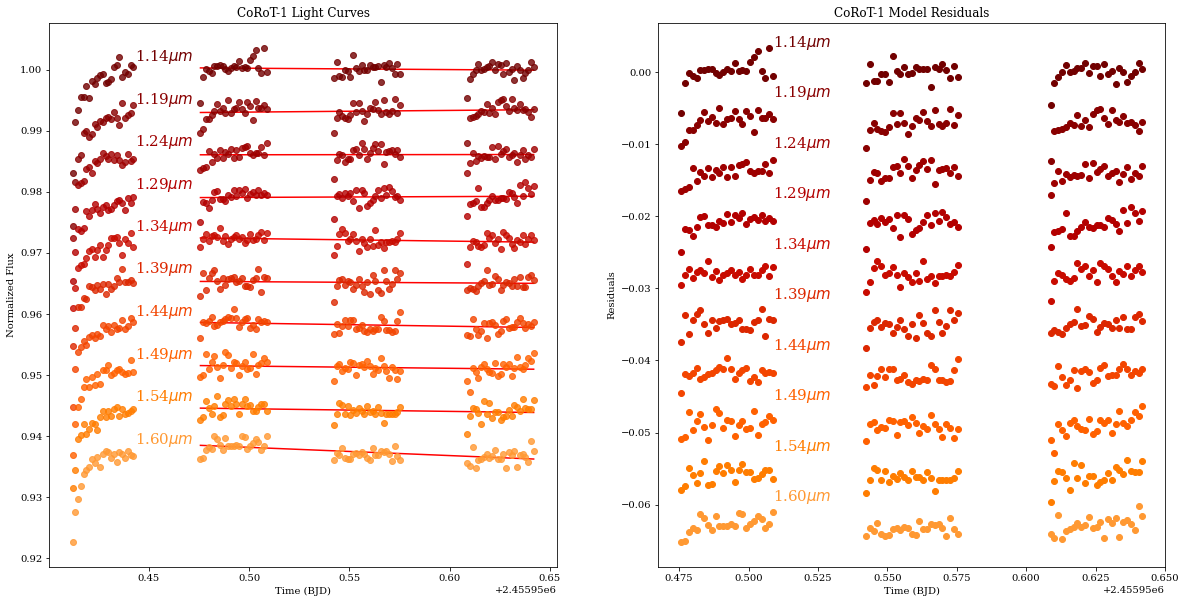

In [22]:
#f=lc_obj.median_image(spec_v1, showPlot=True)
#g=lc_obj.barycenter_correction(spec_v1)
#h =lc_obj.transit_model_RECTE(lc_obj.x, 0.1,1.0,0.0, 200, 200, 20, 0)
#%timeit h=lc_obj.transit_model_RECTE(lc_obj.x, 0.1,1.0,0.0, 200, 200, 20, 0)
#%timeit h=lc_obj.transit_model(lc_obj.x, 0.1,1.0,0.0)
#h =lc_obj.eclipse_model_RECTE(lc_obj.x, 700,1.0,0.0, 200, 200, 20, 0)

#plt.plot(lc_obj.x, h,'.')

f=lc_obj.optimize_batman_model(spec_v2, lc_obj.eclipse_model, nbins=10, showPlot=True, recalculate=True)
#f=lc_obj.optimize_batman_model_RECTE(spec_v1, lc_obj.transit_model_RECTE, nbins=1, showPlot=True, recalculate=False)

In [214]:
dat = ascii.read("/home/kglidic/Software/tshirt_files/tshirt/Corot1_Data/Generalization_Test/optimize_batman_model/CoRoT-1_LightCurve_visit1_wavelength_ind_112.500um Flux.csv")
Time = np.array(dat['Time'])
len(Time)

75

In [ ]:
def optimize_batman_model(self,model,nbins=10,showPlot=False):
    """
    Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
    This function does not consider RECTE charge trapping parameters. 
    This function utilizies the scipy.optimize.curve_fit model fitting approach. 
    
    Parameters
    ----------
    
    self: keyword
        Spectrometry Object
    
    model: function
        A function that models either transits or secondary eclipses. Must be previously defined.
    
    nbins: int
        The number of wavelength bins. The Default is "nbins=10".
        
    showPlot: bool
        Make the plot visible? The Default is "False"
        
    """
   
    #Obtain a table of the the wavelength-binned time series. 
    #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
    results = self.get_wavebin_series(nbins=nbins)
    raw_results = results[0].to_pandas()
    raw_results_errors = results[1].to_pandas()
    
    #Call the barycenter time correction function. Will return correction in days. 
    time_correction = barycenter_correction(self)
    
    #Define the axis columns as well as the corresponding errors.
    ydata_columns = raw_results.columns[1:].values #Skip over the time column
    ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
    xdata = raw_results['Time'].values+time_correction #Time column data in terms of days accounting for Solar barycenter correction

    #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
    table_noise = self.print_noise_wavebin(nbins=nbins)
    table_noise=table_noise.to_pandas() #convert to a pandas table
    
    #Wavelength calibration to turn the dispersion pixels into wavelengths. 
    #CoRoT-1 b used wavecalMethod='wfc3Dispersion' for the HST WFC3 grism 
    wavelength_list = self.wavecal(table_noise['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
    
    #Define empty lists to store scipy.optimize.curve_fit results.
    popt_list=[] #Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
    pcov_list=[] #List of one standard deviation errors on the parameters. 
    
    #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
    if(model==transit_model):
        text = 'fit: pr=%5.3f, a=%5.3f, b=%5.3f'
        p0 = [0.13,1.0,0.0] #each guess value in the list corresponds to the parameter order in text
    elif(model ==eclipse_model):
        text = 'fit: fp=%5.3f, a=%5.3f, b=%5.3f'
        p0 = [500,1.0,0.0] #each guess value in the list corresponds to the parameter order in text
    else: 
        print("Invalid Model Input") #This function only works on the above previously defined models!
     
    #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
    for columns, columns_errors, wavelength in zip(ydata_columns,ydata_errors_columns,wavelength_list):
        
        #Trim the data used in the model. Exclude the first orbit in each visit since RECTE is not optimized here and the ramp profile is still prevalent. 
        #Specific to CoRoT-1 b data, first orbit ends at data point 23. This will change depending on data. 
        xdata_trimmed = xdata[23:]  
        ydata_trimmed = raw_results[columns][23:]
        ydata_error_trimmed = raw_results_errors[columns_errors][23:].tolist() #Convert error data to a list in order to use in scipy.optimize.curve_fit 
        
        #Call and run scipy.optimize.curve_fit. 
        #Returns an array of optimal values for the parameters (popt) and an array for the the estimated covariance of popt (pcov).
        popt, pcov = curve_fit(model,xdata_trimmed,ydata_trimmed,sigma=ydata_error_trimmed,p0=p0)
       
        #Append these returned arrays into the previously defined empty lists.
        popt_list.append(popt)
        pcov_list.append(np.sqrt(np.diag(pcov))) #To compute one standard deviation errors on the parameters
        
        #Light Curve Plotting Options
        if(showPlot==True):
            
            fig, ax =plt.subplots() #Define the figure space
            
            #Plot all orbitial data but, the model excludes the first orbit.
            ax.plot(xdata_trimmed, model(xdata_trimmed, *popt), 'r-',
                    label=text % tuple(popt)) #The *popt will grab the optimized parameters required for the model. 

            ax.plot(xdata, raw_results[columns],'o') #Plot the time data vs. initial flux data
            
            #Axis labels
            ax.set_xlabel('Time (JD)')
            ax.set_ylabel('Normalized Flux')
            ax.set_title('Wavelength ='+str(wavelength))

    return popt_list,pcov_list